In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

df_all = pd.read_csv("features_63_label_2.csv", header=0, encoding="utf-8").drop(["Unnamed: 0"], axis=1)
df_user_id = df_all["user_id"]
df_label = df_all["award_id"].factorize()[0]
df_all.drop(["user_id", "award_id"], axis=1, inplace=True)
dense_mapping = {
    "专业选修课成绩": "po_grade",
    "专业选修课学分": "po_credit",
    "专业必修课成绩": "pm_grade",
    "专业必修课学分": "pm_credit",
    "选修课成绩": "op_grade",
    "选修课学分": "op_credit",
    "公共必修课成绩": "cm_grade",
    "公共必修课学分": "cm_credit",
    "未分类课成绩": "uc_grade",
    "未分类课学分": "uc_credit",
    "总成绩": "tl_grade", 
    "总学分": "tl_credit",
}
df_all.rename(columns=dense_mapping, inplace=True)
col = list(df_all.columns)
sparse_features = col[: -12]
sparse_features

['paper_count',
 'paper_authOrder_0',
 'paper_conferenceChoice_0',
 'paper_paperState_0',
 'paper_labels_0',
 'paper_authOrder_1',
 'paper_conferenceChoice_1',
 'paper_paperState_1',
 'paper_labels_1',
 'paper_authOrder_2',
 'paper_conferenceChoice_2',
 'paper_paperState_2',
 'paper_labels_2',
 'patent_record_count',
 'patent_record_classify_0',
 'patent_record_classify_1',
 'patent_record_classify_2',
 'research_award_count',
 'research_award_competeRange_0',
 'research_award_awardLevel_0',
 'research_award_labels_0',
 'research_award_competeRange_1',
 'research_award_awardLevel_1',
 'research_award_labels_1',
 'research_award_competeRange_2',
 'research_award_awardLevel_2',
 'research_award_labels_2',
 'research_project_count',
 'research_project_projectType_0',
 'research_project_projectType_1',
 'research_project_projectType_2',
 'competition_award_count',
 'competition_award_competeRange_0',
 'competition_award_awardLevel_0',
 'competition_award_labels_0',
 'competition_award_comp

In [6]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

num_round = 1000

data = df_all.copy()

## category feature one_hot
cate_feature = sparse_features
for item in cate_feature:
    if "count" in item:
        cate_feature.remove(item)
        continue
    data[item] = LabelEncoder().fit_transform(data[item])
    item_dummies = pd.get_dummies(data[item])
    item_dummies.columns = [item + str(i + 1) for i in range(item_dummies.shape[1])]
    data = pd.concat([data, item_dummies], axis=1)
data.drop(cate_feature,axis=1,inplace=True)

In [8]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
# from xgboost.sklearn import XGBClassifier
import gc
from xgboost import plot_importance
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve, mean_squared_error, zero_one_loss

In [12]:
import random

# train_x, test_x, train_y, test_y = train_test_split(data, data_y, test_size=0.1, random_state=100)

train_x, test_x, train_y, test_y = train_test_split(data, df_label, test_size=0.2, random_state=random.randint(1, 200))

In [13]:
dtrain = xgb.DMatrix(data=train_x, label=train_y, missing=-999.0)
dtest = xgb.DMatrix(data=test_x, label=test_y, missing=-999.0)

In [16]:
import hyperopt
from hyperopt import fmin, tpe, hp, partial, STATUS_OK, Trials

def hyperopt_objective(params):
    
    model = xgb.XGBClassifier(n_estimators = params['n_estimators'],
                            max_depth = int(params['max_depth']),
                            learning_rate = params['learning_rate'],
                            gamma = params['gamma'],
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'],
                            colsample_bytree = params['colsample_bytree'],
                            num_class=2,
                            objective="multi:softmax",
                            # eval_metric="auc",
                            # auc doesn't work with multi-classification https://github.com/dmlc/xgboost/issues/1208
                            eval_metric="mlogloss",
                            seed=31415926,
                            nthread=-1,
                            silent=1
                            )
     
    res = xgb.cv(model.get_params(), dtrain, num_boost_round=30, nfold=5,
             callbacks=[xgb.callback.print_evaluation(show_stdv=False),
                        xgb.callback.early_stop(5)])
    
    # return np.min(res['test-mlogloss-mean']) # as hyperopt minimises
    return np.min(res['test-mlogloss-mean'])

In [17]:
params_space = {
    'max_depth' : hp.choice('max_depth', range(5, 30, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
    'n_estimators' : hp.choice('n_estimators', range(20, 205, 5)),
    'gamma' : hp.quniform('gamma', 0, 1.0, 0.01),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.01),
    'booster': 'gbtree',
    'tree_method': 'exact',
    'silent': 1,
}

In [18]:
from numpy.random import RandomState

trials = hyperopt.Trials()

best = fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=RandomState(123)
)

print("\n展示hyperopt获取的最佳结果，但是要注意的是我们对hyperopt最初的取值范围做过一次转换")
print(best)

[0]	train-mlogloss:0.642293	test-mlogloss:0.647345     

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.

[1]	train-mlogloss:0.603955	test-mlogloss:0.615632     

[2]	train-mlogloss:0.567479	test-mlogloss:0.596924     

[3]	train-mlogloss:0.543796	test-mlogloss:0.579651     

[4]	train-mlogloss:0.515597	test-mlogloss:0.562931     

[5]	train-mlogloss:0.495439	test-mlogloss:0.551522     

[6]	train-mlogloss:0.478448	test-mlogloss:0.539741     

[7]	train-mlogloss:0.463786	test-mlogloss:0.529741     

[8]	train-mlogloss:0.449032	test-mlogloss:0.524667     

[9]	train-mlogloss:0.437235	test-mlogloss:0.520202     

[10]	train-mlogloss:0.424875	test-mlogloss:0.513719    

[11]	train-mlogloss:0.415311	test-mlogloss:0.507612    

[12]	train-mlogloss:0.404244	test-mlogloss:0.506217    

[13]	train-mlogloss:0.388959	test-mlogloss:0.504638    

[14]	train-mlogloss:0.383457	test-mlogloss:0.50550

Will train until test-mlogloss hasn't improved in 5 rounds.             

[1]	train-mlogloss:0.670039	test-mlogloss:0.67238                       

[2]	train-mlogloss:0.660624	test-mlogloss:0.664389                      

[3]	train-mlogloss:0.652366	test-mlogloss:0.657246                      

[4]	train-mlogloss:0.645034	test-mlogloss:0.650467                      

[5]	train-mlogloss:0.637332	test-mlogloss:0.643737                      

[6]	train-mlogloss:0.629769	test-mlogloss:0.637207                      

[7]	train-mlogloss:0.623234	test-mlogloss:0.632004                      

[8]	train-mlogloss:0.617215	test-mlogloss:0.626623                      

[9]	train-mlogloss:0.611204	test-mlogloss:0.622239                      

[10]	train-mlogloss:0.605806	test-mlogloss:0.617798                     

[11]	train-mlogloss:0.600983	test-mlogloss:0.614464                     

[12]	train-mlogloss:0.596416	test-mlogloss:0.612325                     

[13]	train-mlogloss:0.591915	test-mlog

[25]	train-mlogloss:0.561195	test-mlogloss:0.579856                     

[26]	train-mlogloss:0.560008	test-mlogloss:0.578951                     

[27]	train-mlogloss:0.558182	test-mlogloss:0.578405                     

[28]	train-mlogloss:0.556701	test-mlogloss:0.578726                     

[29]	train-mlogloss:0.555691	test-mlogloss:0.578166                     

[0]	train-mlogloss:0.522294	test-mlogloss:0.577402                      

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.             

[1]	train-mlogloss:0.434373	test-mlogloss:0.52838                       

[2]	train-mlogloss:0.363192	test-mlogloss:0.505105                      

[3]	train-mlogloss:0.318496	test-mlogloss:0.49307                       

[4]	train-mlogloss:0.282701	test-mlogloss:0.465768                      

[5]	train-mlogloss:0.256853	test-mlogloss:0.45541                       

[6]	train-mlogloss:0.

[13]	train-mlogloss:0.507821	test-mlogloss:0.578097                                

[14]	train-mlogloss:0.503473	test-mlogloss:0.575765                                

[15]	train-mlogloss:0.496849	test-mlogloss:0.587448                                

[16]	train-mlogloss:0.494696	test-mlogloss:0.59319                                 

[17]	train-mlogloss:0.488568	test-mlogloss:0.590062                                

[18]	train-mlogloss:0.487479	test-mlogloss:0.590834                                

[19]	train-mlogloss:0.481999	test-mlogloss:0.579674                                

Stopping. Best iteration:                                                          
[14]	train-mlogloss:0.503473+0.0294111	test-mlogloss:0.575765+0.0583652


[0]	train-mlogloss:0.646218	test-mlogloss:0.644812                                 

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.            

[12]	train-mlogloss:0.258527	test-mlogloss:0.493093                                

Stopping. Best iteration:                                                          
[7]	train-mlogloss:0.335857+0.0172252	test-mlogloss:0.477116+0.0780589


[0]	train-mlogloss:0.653435	test-mlogloss:0.662627                                 

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.                        

[1]	train-mlogloss:0.622423	test-mlogloss:0.637987                                 

[2]	train-mlogloss:0.591745	test-mlogloss:0.618882                                 

[3]	train-mlogloss:0.566163	test-mlogloss:0.602228                                 

[4]	train-mlogloss:0.542754	test-mlogloss:0.588125                                 

[5]	train-mlogloss:0.522791	test-mlogloss:0.575799                                 

[6]	train-mlogloss:0.503064	test-mlogloss:0.566101                      

[6]	train-mlogloss:0.342106	test-mlogloss:0.500505                                 

[7]	train-mlogloss:0.325971	test-mlogloss:0.500052                                 

[8]	train-mlogloss:0.31055	test-mlogloss:0.493621                                  

[9]	train-mlogloss:0.301151	test-mlogloss:0.499917                                 

Stopping. Best iteration:                                                          
[4]	train-mlogloss:0.384051+0.0178878	test-mlogloss:0.493619+0.0824052


[0]	train-mlogloss:0.51242	test-mlogloss:0.57963                                   

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.                        

[1]	train-mlogloss:0.429038	test-mlogloss:0.510564                                 

[2]	train-mlogloss:0.359706	test-mlogloss:0.470574                                 

[3]	train-mlogloss:0.318583	test-mlogloss:0.461061                      

[3]	train-mlogloss:0.414709	test-mlogloss:0.503918                                 

[4]	train-mlogloss:0.383902	test-mlogloss:0.498596                                 

[5]	train-mlogloss:0.358459	test-mlogloss:0.49828                                  

[6]	train-mlogloss:0.33848	test-mlogloss:0.49263                                   

[7]	train-mlogloss:0.323728	test-mlogloss:0.488298                                 

[8]	train-mlogloss:0.317526	test-mlogloss:0.485426                                 

[9]	train-mlogloss:0.307854	test-mlogloss:0.484427                                 

[10]	train-mlogloss:0.295252	test-mlogloss:0.49291                                 

[11]	train-mlogloss:0.290085	test-mlogloss:0.498733                                

[12]	train-mlogloss:0.285506	test-mlogloss:0.501115                                

[13]	train-mlogloss:0.280612	test-mlogloss:0.502497                                

[14]	train-mlogloss:0.276773	test-mlogloss:0.500597              

[0]	train-mlogloss:0.532888	test-mlogloss:0.592082                                 

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.                        

[1]	train-mlogloss:0.450703	test-mlogloss:0.5332                                   

[2]	train-mlogloss:0.383654	test-mlogloss:0.490675                                 

[3]	train-mlogloss:0.34743	test-mlogloss:0.477862                                  

[4]	train-mlogloss:0.309147	test-mlogloss:0.462541                                 

[5]	train-mlogloss:0.289926	test-mlogloss:0.455615                                 

[6]	train-mlogloss:0.270761	test-mlogloss:0.45009                                  

[7]	train-mlogloss:0.262862	test-mlogloss:0.465282                                 

[8]	train-mlogloss:0.255417	test-mlogloss:0.46064                                  

[9]	train-mlogloss:0.246956	test-mlogloss:0.458168         

[2]	train-mlogloss:0.532837	test-mlogloss:0.583938                                 

[3]	train-mlogloss:0.49779	test-mlogloss:0.569117                                  

[4]	train-mlogloss:0.474239	test-mlogloss:0.554317                                 

[5]	train-mlogloss:0.4537	test-mlogloss:0.545365                                   

[6]	train-mlogloss:0.432994	test-mlogloss:0.537443                                 

[7]	train-mlogloss:0.415754	test-mlogloss:0.529789                                 

[8]	train-mlogloss:0.404104	test-mlogloss:0.521839                                 

[9]	train-mlogloss:0.391347	test-mlogloss:0.520869                                 

[10]	train-mlogloss:0.380995	test-mlogloss:0.519706                                

[11]	train-mlogloss:0.372049	test-mlogloss:0.521544                                

[12]	train-mlogloss:0.365401	test-mlogloss:0.52233                                 

[13]	train-mlogloss:0.355555	test-mlogloss:0.528396              

[5]	train-mlogloss:0.508781	test-mlogloss:0.581678                                 

[6]	train-mlogloss:0.497679	test-mlogloss:0.575165                                 

[7]	train-mlogloss:0.490492	test-mlogloss:0.575958                                 

[8]	train-mlogloss:0.482641	test-mlogloss:0.574314                                 

[9]	train-mlogloss:0.476719	test-mlogloss:0.570306                                 

[10]	train-mlogloss:0.468428	test-mlogloss:0.573302                                

[11]	train-mlogloss:0.464677	test-mlogloss:0.574561                                

[12]	train-mlogloss:0.45792	test-mlogloss:0.582447                                 

[13]	train-mlogloss:0.450399	test-mlogloss:0.582737                                

[14]	train-mlogloss:0.447269	test-mlogloss:0.587154                                

Stopping. Best iteration:                                                          
[9]	train-mlogloss:0.476719+0.0162331	test-mlogloss:0.570306+0.084

[3]	train-mlogloss:0.470877	test-mlogloss:0.558573                                 

[4]	train-mlogloss:0.438301	test-mlogloss:0.56074                                  

[5]	train-mlogloss:0.420918	test-mlogloss:0.569557                                 

[6]	train-mlogloss:0.404456	test-mlogloss:0.561226                                 

[7]	train-mlogloss:0.39581	test-mlogloss:0.559112                                  

[8]	train-mlogloss:0.389384	test-mlogloss:0.561961                                 

Stopping. Best iteration:                                                          
[3]	train-mlogloss:0.470877+0.0207422	test-mlogloss:0.558573+0.0876954


[0]	train-mlogloss:0.601555	test-mlogloss:0.613408                                 

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.                        

[1]	train-mlogloss:0.546584	test-mlogloss:0.569663                      

Will train until test-mlogloss hasn't improved in 5 rounds.                        

[1]	train-mlogloss:0.617781	test-mlogloss:0.630368                                 

[2]	train-mlogloss:0.609111	test-mlogloss:0.621159                                 

[3]	train-mlogloss:0.60809	test-mlogloss:0.625218                                  

[4]	train-mlogloss:0.605982	test-mlogloss:0.614945                                 

[5]	train-mlogloss:0.604667	test-mlogloss:0.611737                                 

[6]	train-mlogloss:0.605591	test-mlogloss:0.611134                                 

[7]	train-mlogloss:0.606727	test-mlogloss:0.612048                                 

[8]	train-mlogloss:0.6073	test-mlogloss:0.612373                                   

[9]	train-mlogloss:0.603694	test-mlogloss:0.608097                                 

[10]	train-mlogloss:0.602211	test-mlogloss:0.614464                                

[11]	train-mlogloss:0.603755	test-mlogloss:0.62243               

[4]	train-mlogloss:0.45883	test-mlogloss:0.526547                                  

[5]	train-mlogloss:0.44298	test-mlogloss:0.518768                                  

[6]	train-mlogloss:0.427003	test-mlogloss:0.509829                                 

[7]	train-mlogloss:0.414286	test-mlogloss:0.50754                                  

[8]	train-mlogloss:0.406606	test-mlogloss:0.503501                                 

[9]	train-mlogloss:0.393745	test-mlogloss:0.495184                                 

[10]	train-mlogloss:0.378355	test-mlogloss:0.497329                                

[11]	train-mlogloss:0.363678	test-mlogloss:0.492066                                

[12]	train-mlogloss:0.352243	test-mlogloss:0.491089                                

[13]	train-mlogloss:0.340034	test-mlogloss:0.490737                                

[14]	train-mlogloss:0.335453	test-mlogloss:0.490646                                

[15]	train-mlogloss:0.328074	test-mlogloss:0.489118              

Will train until test-mlogloss hasn't improved in 5 rounds.                        

[1]	train-mlogloss:0.494303	test-mlogloss:0.507087                                 

[2]	train-mlogloss:0.445875	test-mlogloss:0.497174                                 

[3]	train-mlogloss:0.410357	test-mlogloss:0.47805                                  

[4]	train-mlogloss:0.374242	test-mlogloss:0.471048                                 

[5]	train-mlogloss:0.351873	test-mlogloss:0.477463                                 

[6]	train-mlogloss:0.336088	test-mlogloss:0.464003                                 

[7]	train-mlogloss:0.321406	test-mlogloss:0.468572                                 

[8]	train-mlogloss:0.303236	test-mlogloss:0.477288                                 

[9]	train-mlogloss:0.289844	test-mlogloss:0.475653                                 

[10]	train-mlogloss:0.27342	test-mlogloss:0.479229                                 

[11]	train-mlogloss:0.265969	test-mlogloss:0.496077              

[6]	train-mlogloss:0.26635	test-mlogloss:0.436007                                  

[7]	train-mlogloss:0.261705	test-mlogloss:0.438359                                 

[8]	train-mlogloss:0.254187	test-mlogloss:0.437628                                 

[9]	train-mlogloss:0.248627	test-mlogloss:0.434795                                 

[10]	train-mlogloss:0.246414	test-mlogloss:0.438733                                

Stopping. Best iteration:                                                          
[5]	train-mlogloss:0.270171+0.0139714	test-mlogloss:0.434554+0.104097


[0]	train-mlogloss:0.551524	test-mlogloss:0.591155                                 

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.                        

[1]	train-mlogloss:0.471704	test-mlogloss:0.537606                                 

[2]	train-mlogloss:0.418577	test-mlogloss:0.513368                       

[12]	train-mlogloss:0.222921	test-mlogloss:0.462047                                

Stopping. Best iteration:                                                          
[7]	train-mlogloss:0.236249+0.0269756	test-mlogloss:0.457262+0.137205


[0]	train-mlogloss:0.509709	test-mlogloss:0.574789                                 

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.                        

[1]	train-mlogloss:0.414765	test-mlogloss:0.530815                                 

[2]	train-mlogloss:0.340407	test-mlogloss:0.498577                                 

[3]	train-mlogloss:0.303024	test-mlogloss:0.473332                                 

[4]	train-mlogloss:0.277368	test-mlogloss:0.451924                                 

[5]	train-mlogloss:0.259284	test-mlogloss:0.445245                                 

[6]	train-mlogloss:0.241976	test-mlogloss:0.4354                         

[3]	train-mlogloss:0.308765	test-mlogloss:0.471184                                 

[4]	train-mlogloss:0.273413	test-mlogloss:0.441112                                 

[5]	train-mlogloss:0.245505	test-mlogloss:0.445279                                 

[6]	train-mlogloss:0.224476	test-mlogloss:0.436305                                 

[7]	train-mlogloss:0.222954	test-mlogloss:0.436759                                 

[8]	train-mlogloss:0.218666	test-mlogloss:0.434737                                 

[9]	train-mlogloss:0.218607	test-mlogloss:0.434956                                 

[10]	train-mlogloss:0.211084	test-mlogloss:0.439039                                

[11]	train-mlogloss:0.209653	test-mlogloss:0.436298                                

[12]	train-mlogloss:0.207019	test-mlogloss:0.437224                                

[13]	train-mlogloss:0.20513	test-mlogloss:0.435664                                 

Stopping. Best iteration:                                        

[15]	train-mlogloss:0.39571	test-mlogloss:0.544962                                 

[16]	train-mlogloss:0.388671	test-mlogloss:0.541375                                

[17]	train-mlogloss:0.382787	test-mlogloss:0.536339                                

[18]	train-mlogloss:0.377918	test-mlogloss:0.542369                                

[19]	train-mlogloss:0.374524	test-mlogloss:0.540094                                

[20]	train-mlogloss:0.36745	test-mlogloss:0.536203                                 

[21]	train-mlogloss:0.363739	test-mlogloss:0.534421                                

[22]	train-mlogloss:0.362661	test-mlogloss:0.535024                                

[23]	train-mlogloss:0.360331	test-mlogloss:0.536525                                

[24]	train-mlogloss:0.356977	test-mlogloss:0.537327                                

[25]	train-mlogloss:0.353042	test-mlogloss:0.53076                                 

[26]	train-mlogloss:0.349865	test-mlogloss:0.531523              

[1]	train-mlogloss:0.403329	test-mlogloss:0.511599                                 

[2]	train-mlogloss:0.333944	test-mlogloss:0.480905                                 

[3]	train-mlogloss:0.285491	test-mlogloss:0.446087                                 

[4]	train-mlogloss:0.254321	test-mlogloss:0.43387                                  

[5]	train-mlogloss:0.227898	test-mlogloss:0.436105                                 

[6]	train-mlogloss:0.208643	test-mlogloss:0.441188                                 

[7]	train-mlogloss:0.197523	test-mlogloss:0.443971                                 

[8]	train-mlogloss:0.191208	test-mlogloss:0.445792                                 

[9]	train-mlogloss:0.186111	test-mlogloss:0.443715                                 

Stopping. Best iteration:                                                          
[4]	train-mlogloss:0.254321+0.024498	test-mlogloss:0.43387+0.101741


[0]	train-mlogloss:0.552284	test-mlogloss:0.618428                               

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.                        

[1]	train-mlogloss:0.539651	test-mlogloss:0.570598                                 

[2]	train-mlogloss:0.509718	test-mlogloss:0.56999                                  

[3]	train-mlogloss:0.49037	test-mlogloss:0.570526                                  

[4]	train-mlogloss:0.469805	test-mlogloss:0.563759                                 

[5]	train-mlogloss:0.460655	test-mlogloss:0.564078                                 

[6]	train-mlogloss:0.451805	test-mlogloss:0.564758                                 

[7]	train-mlogloss:0.446551	test-mlogloss:0.561114                                 

[8]	train-mlogloss:0.444774	test-mlogloss:0.556543                                 

[9]	train-mlogloss:0.439233	test-mlogloss:0.560244                                 

[10]	train-mlogloss:0.43367	test-mlogloss:0.561538         

[13]	train-mlogloss:0.11634	test-mlogloss:0.436454                                 

Stopping. Best iteration:                                                          
[8]	train-mlogloss:0.151264+0.00768678	test-mlogloss:0.42554+0.114588


[0]	train-mlogloss:0.598796	test-mlogloss:0.613474                                 

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.                        

[1]	train-mlogloss:0.561185	test-mlogloss:0.574869                                 

[2]	train-mlogloss:0.528629	test-mlogloss:0.585237                                 

[3]	train-mlogloss:0.506344	test-mlogloss:0.579955                                 

[4]	train-mlogloss:0.490512	test-mlogloss:0.581952                                 

[5]	train-mlogloss:0.480647	test-mlogloss:0.5809                                   

[6]	train-mlogloss:0.4664	test-mlogloss:0.573649                         

Final CrossValMean:  0.78
accuracy: 0.6153846153846154


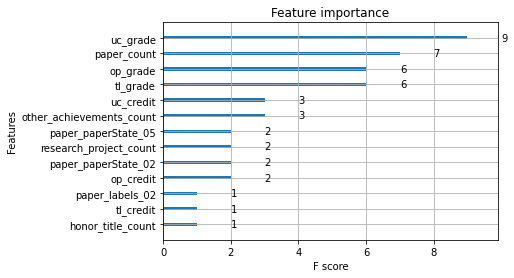

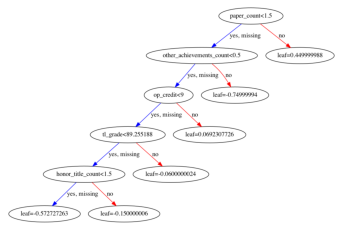

In [19]:
classifier = xgb.XGBClassifier(n_estimators = best['n_estimators'],
                            max_depth = best['max_depth'],
                            learning_rate = best['learning_rate'],
                            gamma = best['gamma'],
                            min_child_weight = best['min_child_weight'],
                            subsample = best['subsample'],
                            colsample_bytree = best['colsample_bytree']
                            )

classifier.fit(train_x, train_y)

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = train_x, y = train_y, cv = 10)
CrossValMean = accuracies.mean()
print("Final CrossValMean: ", CrossValMean)

CrossValSTD = accuracies.std()

# Predicting the Test set results
y_pred = classifier.predict(test_x)
y_pred = pd.DataFrame(y_pred)

print("accuracy: " + str(accuracy_score(y_pred, test_y)))
xgb.plot_importance(classifier)
xgb.plot_tree(classifier)

In [25]:
classifier.get_booster().save_model("2-class_accuracy=0.615_63_features.xgb")

### 上面是一种

In [20]:
data = df_all.copy()

In [23]:
train_x, test_x, train_y, test_y = train_test_split(data, df_label, test_size=0.2, random_state=random.randint(1, 200))

In [24]:
dtrain = xgb.DMatrix(data=train_x, label=train_y, missing=-999.0)
dtest = xgb.DMatrix(data=test_x, label=test_y, missing=-999.0)

In [26]:
from numpy.random import RandomState

trials = hyperopt.Trials()

best = fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=RandomState(123)
)

print("\n展示hyperopt获取的最佳结果，但是要注意的是我们对hyperopt最初的取值范围做过一次转换")
print(best)

[0]	train-mlogloss:0.634368	test-mlogloss:0.653611     

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.

[1]	train-mlogloss:0.590371	test-mlogloss:0.617923     

[2]	train-mlogloss:0.559327	test-mlogloss:0.595223     

[3]	train-mlogloss:0.525873	test-mlogloss:0.572361     

[4]	train-mlogloss:0.500567	test-mlogloss:0.556958     

[5]	train-mlogloss:0.476884	test-mlogloss:0.543615     

[6]	train-mlogloss:0.45601	test-mlogloss:0.537198      

[7]	train-mlogloss:0.436121	test-mlogloss:0.524908     

[8]	train-mlogloss:0.42021	test-mlogloss:0.518411      

[9]	train-mlogloss:0.40798	test-mlogloss:0.511085      

[10]	train-mlogloss:0.395599	test-mlogloss:0.508796    

[11]	train-mlogloss:0.377858	test-mlogloss:0.501283    

[12]	train-mlogloss:0.369169	test-mlogloss:0.503261    

[13]	train-mlogloss:0.362088	test-mlogloss:0.501655    

[14]	train-mlogloss:0.356275	test-mlogloss:0.50393

[3]	train-mlogloss:0.65152	test-mlogloss:0.655068                                

[4]	train-mlogloss:0.643181	test-mlogloss:0.647464                               

[5]	train-mlogloss:0.635383	test-mlogloss:0.641222                               

[6]	train-mlogloss:0.629398	test-mlogloss:0.637032                               

[7]	train-mlogloss:0.622688	test-mlogloss:0.630685                               

[8]	train-mlogloss:0.615811	test-mlogloss:0.626067                               

[9]	train-mlogloss:0.609869	test-mlogloss:0.621551                               

[10]	train-mlogloss:0.604824	test-mlogloss:0.616129                              

[11]	train-mlogloss:0.599746	test-mlogloss:0.613156                              

[12]	train-mlogloss:0.594478	test-mlogloss:0.610001                              

[13]	train-mlogloss:0.589619	test-mlogloss:0.607293                              

[14]	train-mlogloss:0.585125	test-mlogloss:0.604443                              

[15]

[3]	train-mlogloss:0.651833	test-mlogloss:0.656527                               

[4]	train-mlogloss:0.645092	test-mlogloss:0.651484                               

[5]	train-mlogloss:0.636773	test-mlogloss:0.644003                               

[6]	train-mlogloss:0.629623	test-mlogloss:0.63783                                

[7]	train-mlogloss:0.622663	test-mlogloss:0.630876                               

[8]	train-mlogloss:0.616133	test-mlogloss:0.626067                               

[9]	train-mlogloss:0.61116	test-mlogloss:0.622071                                

[10]	train-mlogloss:0.605435	test-mlogloss:0.616376                              

[11]	train-mlogloss:0.60054	test-mlogloss:0.613574                               

[12]	train-mlogloss:0.596751	test-mlogloss:0.610802                              

[13]	train-mlogloss:0.592253	test-mlogloss:0.606762                              

[14]	train-mlogloss:0.589062	test-mlogloss:0.604279                              

[15]

[4]	train-mlogloss:0.553552	test-mlogloss:0.569846                                

[5]	train-mlogloss:0.555732	test-mlogloss:0.569907                                

[6]	train-mlogloss:0.544652	test-mlogloss:0.588079                                

[7]	train-mlogloss:0.53262	test-mlogloss:0.59235                                  

[8]	train-mlogloss:0.526893	test-mlogloss:0.56862                                 

[9]	train-mlogloss:0.523828	test-mlogloss:0.574737                                

[10]	train-mlogloss:0.512083	test-mlogloss:0.556457                               

[11]	train-mlogloss:0.504812	test-mlogloss:0.561757                               

[12]	train-mlogloss:0.487848	test-mlogloss:0.575022                               

[13]	train-mlogloss:0.483268	test-mlogloss:0.57036                                

[14]	train-mlogloss:0.480421	test-mlogloss:0.599405                               

[15]	train-mlogloss:0.476072	test-mlogloss:0.602335                         

[6]	train-mlogloss:0.341792	test-mlogloss:0.545845                       

[7]	train-mlogloss:0.320758	test-mlogloss:0.543181                       

[8]	train-mlogloss:0.302473	test-mlogloss:0.540525                       

[9]	train-mlogloss:0.287438	test-mlogloss:0.539227                       

[10]	train-mlogloss:0.274076	test-mlogloss:0.539515                      

[11]	train-mlogloss:0.258181	test-mlogloss:0.545411                      

[12]	train-mlogloss:0.25	test-mlogloss:0.55294                           

[13]	train-mlogloss:0.240626	test-mlogloss:0.555672                      

[14]	train-mlogloss:0.232126	test-mlogloss:0.567926                      

Stopping. Best iteration:                                                
[9]	train-mlogloss:0.287438+0.0147968	test-mlogloss:0.539227+0.122285


[0]	train-mlogloss:0.65264	test-mlogloss:0.671692                        

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train un

[15]	train-mlogloss:0.318997	test-mlogloss:0.496755                      

[16]	train-mlogloss:0.310238	test-mlogloss:0.499957                      

[17]	train-mlogloss:0.3076	test-mlogloss:0.496792                        

Stopping. Best iteration:                                                
[12]	train-mlogloss:0.331326+0.0139353	test-mlogloss:0.495987+0.107076


[0]	train-mlogloss:0.625874	test-mlogloss:0.650621                       

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.              

[1]	train-mlogloss:0.563257	test-mlogloss:0.613903                       

[2]	train-mlogloss:0.528567	test-mlogloss:0.584724                       

[3]	train-mlogloss:0.496082	test-mlogloss:0.558727                       

[4]	train-mlogloss:0.472196	test-mlogloss:0.551612                       

[5]	train-mlogloss:0.44848	test-mlogloss:0.543506                        

[6]	train-ml

[2]	train-mlogloss:0.453691	test-mlogloss:0.536736                      

[3]	train-mlogloss:0.417146	test-mlogloss:0.516448                      

[4]	train-mlogloss:0.395122	test-mlogloss:0.527564                      

[5]	train-mlogloss:0.379565	test-mlogloss:0.524478                      

[6]	train-mlogloss:0.368222	test-mlogloss:0.521071                      

[7]	train-mlogloss:0.365867	test-mlogloss:0.519106                      

[8]	train-mlogloss:0.362839	test-mlogloss:0.518934                      

Stopping. Best iteration:                                               
[3]	train-mlogloss:0.417146+0.0253141	test-mlogloss:0.516448+0.0565357


[0]	train-mlogloss:0.565302	test-mlogloss:0.6231                        

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.             

[1]	train-mlogloss:0.493451	test-mlogloss:0.571832                      

[2]	train-mlogloss:0.43

[11]	train-mlogloss:0.236064	test-mlogloss:0.516195                     

[12]	train-mlogloss:0.234335	test-mlogloss:0.520281                     

[13]	train-mlogloss:0.234319	test-mlogloss:0.519263                     

Stopping. Best iteration:                                               
[8]	train-mlogloss:0.251786+0.017806	test-mlogloss:0.504609+0.131377


[0]	train-mlogloss:0.61129	test-mlogloss:0.636946                       

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.             

[1]	train-mlogloss:0.568567	test-mlogloss:0.605442                      

[2]	train-mlogloss:0.536688	test-mlogloss:0.581096                      

[3]	train-mlogloss:0.510749	test-mlogloss:0.56531                       

[4]	train-mlogloss:0.492531	test-mlogloss:0.567764                      

[5]	train-mlogloss:0.476085	test-mlogloss:0.573737                      

[6]	train-mlogloss:0.4639

[19]	train-mlogloss:0.286545	test-mlogloss:0.555982                     

[20]	train-mlogloss:0.278414	test-mlogloss:0.554374                     

Stopping. Best iteration:                                               
[15]	train-mlogloss:0.323831+0.0152734	test-mlogloss:0.546944+0.0944129


[0]	train-mlogloss:0.622595	test-mlogloss:0.624554                      

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.             

[1]	train-mlogloss:0.583729	test-mlogloss:0.597619                      

[2]	train-mlogloss:0.557859	test-mlogloss:0.578835                      

[3]	train-mlogloss:0.541352	test-mlogloss:0.571671                      

[4]	train-mlogloss:0.526474	test-mlogloss:0.577388                      

[5]	train-mlogloss:0.519698	test-mlogloss:0.569636                      

[6]	train-mlogloss:0.510342	test-mlogloss:0.571221                      

[7]	train-mlogloss:0.4

[26]	train-mlogloss:0.454888	test-mlogloss:0.551127                     

[27]	train-mlogloss:0.45245	test-mlogloss:0.549092                      

[28]	train-mlogloss:0.450185	test-mlogloss:0.548327                     

[29]	train-mlogloss:0.448916	test-mlogloss:0.54916                      

[0]	train-mlogloss:0.565817	test-mlogloss:0.584894                      

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.             

[1]	train-mlogloss:0.519891	test-mlogloss:0.560333                      

[2]	train-mlogloss:0.487145	test-mlogloss:0.569919                      

[3]	train-mlogloss:0.457746	test-mlogloss:0.553103                      

[4]	train-mlogloss:0.442466	test-mlogloss:0.551163                      

[5]	train-mlogloss:0.429588	test-mlogloss:0.539094                      

[6]	train-mlogloss:0.41318	test-mlogloss:0.538272                       

[7]	train-mlogloss:0.

[6]	train-mlogloss:0.639827	test-mlogloss:0.642031                      

[7]	train-mlogloss:0.63866	test-mlogloss:0.641792                       

[8]	train-mlogloss:0.636257	test-mlogloss:0.640166                      

[9]	train-mlogloss:0.634458	test-mlogloss:0.638681                      

[10]	train-mlogloss:0.632457	test-mlogloss:0.635416                     

[11]	train-mlogloss:0.631314	test-mlogloss:0.63488                      

[12]	train-mlogloss:0.630594	test-mlogloss:0.635079                     

[13]	train-mlogloss:0.630036	test-mlogloss:0.63452                      

[14]	train-mlogloss:0.630659	test-mlogloss:0.635598                     

[15]	train-mlogloss:0.629608	test-mlogloss:0.633751                     

[16]	train-mlogloss:0.629587	test-mlogloss:0.633785                     

[17]	train-mlogloss:0.628437	test-mlogloss:0.63291                      

[18]	train-mlogloss:0.628128	test-mlogloss:0.63342                      

[19]	train-mlogloss:0.627527	test-mlog

[11]	train-mlogloss:0.468777	test-mlogloss:0.565494                     

[12]	train-mlogloss:0.462813	test-mlogloss:0.562802                     

[13]	train-mlogloss:0.457604	test-mlogloss:0.561941                     

[14]	train-mlogloss:0.452852	test-mlogloss:0.562448                     

[15]	train-mlogloss:0.449462	test-mlogloss:0.564651                     

[16]	train-mlogloss:0.443507	test-mlogloss:0.5608                       

[17]	train-mlogloss:0.438649	test-mlogloss:0.558595                     

[18]	train-mlogloss:0.434504	test-mlogloss:0.557535                     

[19]	train-mlogloss:0.430687	test-mlogloss:0.556725                     

[20]	train-mlogloss:0.427004	test-mlogloss:0.55369                      

[21]	train-mlogloss:0.421938	test-mlogloss:0.552621                     

[22]	train-mlogloss:0.418935	test-mlogloss:0.553051                     

[23]	train-mlogloss:0.416897	test-mlogloss:0.553646                     

[24]	train-mlogloss:0.413786	test-mlog

[2]	train-mlogloss:0.498967	test-mlogloss:0.585456                      

[3]	train-mlogloss:0.465798	test-mlogloss:0.576353                      

[4]	train-mlogloss:0.449343	test-mlogloss:0.573767                      

[5]	train-mlogloss:0.430197	test-mlogloss:0.564805                      

[6]	train-mlogloss:0.415611	test-mlogloss:0.565318                      

[7]	train-mlogloss:0.403472	test-mlogloss:0.556679                      

[8]	train-mlogloss:0.391829	test-mlogloss:0.565485                      

[9]	train-mlogloss:0.38261	test-mlogloss:0.562519                       

[10]	train-mlogloss:0.377735	test-mlogloss:0.563372                     

[11]	train-mlogloss:0.370371	test-mlogloss:0.570264                     

[12]	train-mlogloss:0.366751	test-mlogloss:0.568486                     

Stopping. Best iteration:                                               
[7]	train-mlogloss:0.403472+0.0281241	test-mlogloss:0.556679+0.0865543


[0]	train-mlogloss:0.680388	test-mloglos

[14]	train-mlogloss:0.230346	test-mlogloss:0.550158                     

[15]	train-mlogloss:0.221146	test-mlogloss:0.540363                     

Stopping. Best iteration:                                               
[10]	train-mlogloss:0.259841+0.0112793	test-mlogloss:0.523169+0.112142


[0]	train-mlogloss:0.629325	test-mlogloss:0.637153                      

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.             

[1]	train-mlogloss:0.596697	test-mlogloss:0.606721                      

[2]	train-mlogloss:0.578726	test-mlogloss:0.587856                      

[3]	train-mlogloss:0.563932	test-mlogloss:0.581643                      

[4]	train-mlogloss:0.552426	test-mlogloss:0.573819                      

[5]	train-mlogloss:0.543401	test-mlogloss:0.570376                      

[6]	train-mlogloss:0.538552	test-mlogloss:0.565348                      

[7]	train-mlogloss:0.53

[14]	train-mlogloss:0.375652	test-mlogloss:0.505185                     

[15]	train-mlogloss:0.369919	test-mlogloss:0.504793                     

[16]	train-mlogloss:0.367478	test-mlogloss:0.501779                     

[17]	train-mlogloss:0.362983	test-mlogloss:0.496813                     

[18]	train-mlogloss:0.359729	test-mlogloss:0.49363                      

[19]	train-mlogloss:0.354781	test-mlogloss:0.491512                     

[20]	train-mlogloss:0.354325	test-mlogloss:0.492337                     

[21]	train-mlogloss:0.352407	test-mlogloss:0.492974                     

[22]	train-mlogloss:0.346023	test-mlogloss:0.489482                     

[23]	train-mlogloss:0.344759	test-mlogloss:0.49005                      

[24]	train-mlogloss:0.343407	test-mlogloss:0.489436                     

[25]	train-mlogloss:0.340473	test-mlogloss:0.489935                     

[26]	train-mlogloss:0.339511	test-mlogloss:0.488145                     

[27]	train-mlogloss:0.339051	test-mlog

[14]	train-mlogloss:0.453839	test-mlogloss:0.556243                     

[15]	train-mlogloss:0.448137	test-mlogloss:0.55247                      

[16]	train-mlogloss:0.443934	test-mlogloss:0.549182                     

[17]	train-mlogloss:0.436998	test-mlogloss:0.544845                     

[18]	train-mlogloss:0.435417	test-mlogloss:0.542733                     

[19]	train-mlogloss:0.43314	test-mlogloss:0.543123                      

[20]	train-mlogloss:0.430216	test-mlogloss:0.543159                     

[21]	train-mlogloss:0.4252	test-mlogloss:0.540228                       

[22]	train-mlogloss:0.421956	test-mlogloss:0.535938                     

[23]	train-mlogloss:0.420492	test-mlogloss:0.535449                     

[24]	train-mlogloss:0.419587	test-mlogloss:0.535753                     

[25]	train-mlogloss:0.417779	test-mlogloss:0.534781                     

[26]	train-mlogloss:0.416333	test-mlogloss:0.530412                     

[27]	train-mlogloss:0.414866	test-mlog

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.             

[1]	train-mlogloss:0.527453	test-mlogloss:0.585711                      

[2]	train-mlogloss:0.480949	test-mlogloss:0.565079                      

[3]	train-mlogloss:0.446536	test-mlogloss:0.532983                      

[4]	train-mlogloss:0.413714	test-mlogloss:0.524044                      

[5]	train-mlogloss:0.388183	test-mlogloss:0.519019                      

[6]	train-mlogloss:0.364546	test-mlogloss:0.514847                      

[7]	train-mlogloss:0.348258	test-mlogloss:0.500479                      

[8]	train-mlogloss:0.339937	test-mlogloss:0.496048                      

[9]	train-mlogloss:0.333648	test-mlogloss:0.491855                      

[10]	train-mlogloss:0.32473	test-mlogloss:0.494639                      

[11]	train-mlogloss:0.312831	test-mlogloss:0.488729                     

[12]	train-mlogloss:0

Will train until test-mlogloss hasn't improved in 5 rounds.             

[1]	train-mlogloss:0.494051	test-mlogloss:0.538736                      

[2]	train-mlogloss:0.457518	test-mlogloss:0.540072                      

[3]	train-mlogloss:0.419156	test-mlogloss:0.533216                      

[4]	train-mlogloss:0.400117	test-mlogloss:0.529316                      

[5]	train-mlogloss:0.381564	test-mlogloss:0.533533                      

[6]	train-mlogloss:0.368514	test-mlogloss:0.534979                      

[7]	train-mlogloss:0.354308	test-mlogloss:0.533754                      

[8]	train-mlogloss:0.344062	test-mlogloss:0.53953                       

[9]	train-mlogloss:0.333793	test-mlogloss:0.539548                      

Stopping. Best iteration:                                               
[4]	train-mlogloss:0.400117+0.0344937	test-mlogloss:0.529316+0.0761229


[0]	train-mlogloss:0.602448	test-mlogloss:0.638975                      

Multiple eval metrics have been passed: 

Will train until test-mlogloss hasn't improved in 5 rounds.             

[1]	train-mlogloss:0.590526	test-mlogloss:0.637512                      

[2]	train-mlogloss:0.551239	test-mlogloss:0.616709                      

[3]	train-mlogloss:0.520982	test-mlogloss:0.599268                      

[4]	train-mlogloss:0.489414	test-mlogloss:0.585296                      

[5]	train-mlogloss:0.46222	test-mlogloss:0.57354                        

[6]	train-mlogloss:0.435928	test-mlogloss:0.56729                       

[7]	train-mlogloss:0.417005	test-mlogloss:0.558307                      

[8]	train-mlogloss:0.398711	test-mlogloss:0.553313                      

[9]	train-mlogloss:0.380956	test-mlogloss:0.546955                      

[10]	train-mlogloss:0.366501	test-mlogloss:0.53917                      

[11]	train-mlogloss:0.350563	test-mlogloss:0.541112                     

[12]	train-mlogloss:0.339245	test-mlogloss:0.540022                     

[13]	train-mlogloss:0.328029	test-mlog

[1]	train-mlogloss:0.637589	test-mlogloss:0.641464                      

[2]	train-mlogloss:0.632556	test-mlogloss:0.636034                      

[3]	train-mlogloss:0.63422	test-mlogloss:0.641863                       

[4]	train-mlogloss:0.629592	test-mlogloss:0.632342                      

[5]	train-mlogloss:0.63371	test-mlogloss:0.643067                       

[6]	train-mlogloss:0.632331	test-mlogloss:0.638286                      

[7]	train-mlogloss:0.63094	test-mlogloss:0.636283                       

[8]	train-mlogloss:0.636387	test-mlogloss:0.641172                      

[9]	train-mlogloss:0.62964	test-mlogloss:0.634047                       

Stopping. Best iteration:                                               
[4]	train-mlogloss:0.629592+0.00839922	test-mlogloss:0.632342+0.0227473


[0]	train-mlogloss:0.600231	test-mlogloss:0.627226                      

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-

[7]	train-mlogloss:0.460403	test-mlogloss:0.558904                      

[8]	train-mlogloss:0.450342	test-mlogloss:0.565605                      

[9]	train-mlogloss:0.439305	test-mlogloss:0.563287                      

[10]	train-mlogloss:0.433595	test-mlogloss:0.564012                     

[11]	train-mlogloss:0.426827	test-mlogloss:0.568666                     

[12]	train-mlogloss:0.422662	test-mlogloss:0.574651                     

Stopping. Best iteration:                                               
[7]	train-mlogloss:0.460403+0.0185766	test-mlogloss:0.558904+0.0637289


[0]	train-mlogloss:0.639615	test-mlogloss:0.649024                      

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.             

[1]	train-mlogloss:0.607925	test-mlogloss:0.623978                      

[2]	train-mlogloss:0.586738	test-mlogloss:0.611932                      

[3]	train-mlogloss:0.56

Final CrossValMean:  0.76
accuracy: 0.8846153846153846


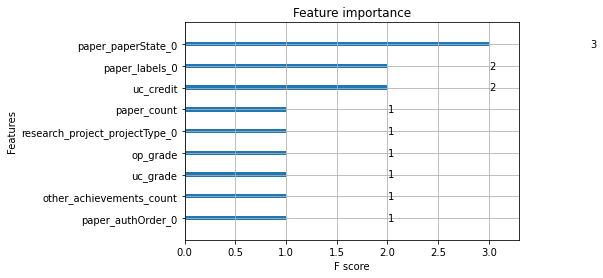

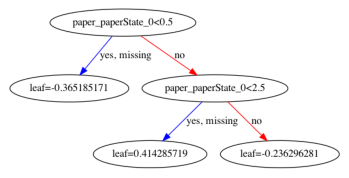

In [27]:
classifier = xgb.XGBClassifier(n_estimators = best['n_estimators'],
                            max_depth = best['max_depth'],
                            learning_rate = best['learning_rate'],
                            gamma = best['gamma'],
                            min_child_weight = best['min_child_weight'],
                            subsample = best['subsample'],
                            colsample_bytree = best['colsample_bytree']
                            )

classifier.fit(train_x, train_y)

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = train_x, y = train_y, cv = 10)
CrossValMean = accuracies.mean()
print("Final CrossValMean: ", CrossValMean)

CrossValSTD = accuracies.std()

# Predicting the Test set results
y_pred = classifier.predict(test_x)
y_pred = pd.DataFrame(y_pred)

print("accuracy: " + str(accuracy_score(y_pred, test_y)))
xgb.plot_importance(classifier)
xgb.plot_tree(classifier)

In [28]:
nmd还是不做one-hot好一点

NameError: name 'nmd还是不做one' is not defined

In [29]:
y_pred = classifier.predict(train_x)
y_pred = pd.DataFrame(y_pred)

print("accuracy: " + str(accuracy_score(y_pred, train_y)))

accuracy: 0.84


In [30]:
classifier.get_booster().save_model("2-class_accuracy=0.88_63_features.xgb")